## 1. Environment Setup

In [ ]:
import os
import random
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, WeightedRandomSampler
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    classification_report, confusion_matrix,
    roc_auc_score, roc_curve, precision_recall_curve, f1_score
)

warnings.filterwarnings('ignore')

SEED = 42
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device:', DEVICE)
if torch.cuda.is_available():
    print('GPU:', torch.cuda.get_device_name(0))

Device: cuda
GPU: Tesla T4


## 2. Exploratory Data Analysis

In [2]:
DATA_DIR     = Path('/kaggle/input/cataractdataset/dataset')
CLASSES      = ['1_normal', '2_glaucoma']
CLASS_NAMES  = ['Normal', 'Glaucoma']
IMG_SIZE     = 224
BATCH_SIZE   = 32
EPOCHS       = 20
LR           = 1e-4
COLORS       = ['#2196F3', '#E53935']

records = []
for label_idx, folder in enumerate(CLASSES):
    folder_path = DATA_DIR / folder
    for ext in ('*.jpg', '*.jpeg', '*.png', '*.bmp'):
        for img_path in folder_path.glob(ext):
            records.append({
                'path':  str(img_path),
                'label': label_idx,
                'class': CLASS_NAMES[label_idx]
            })

df = pd.DataFrame(records)
print('Total images:', len(df))
print(df['class'].value_counts())

Total images: 401
class
Normal      300
Glaucoma    101
Name: count, dtype: int64


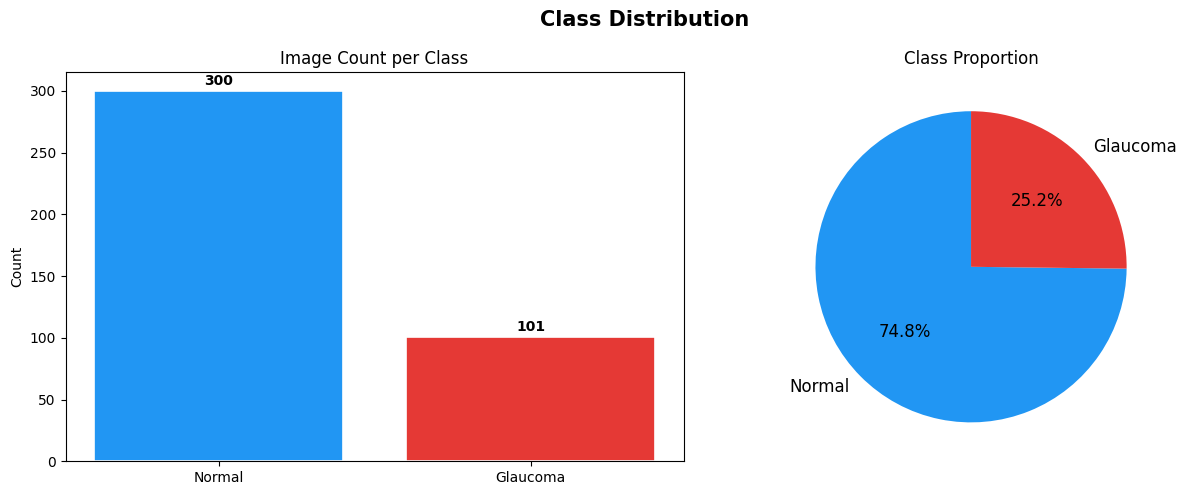

Imbalance ratio: 2.97x
Class imbalance detected. WeightedRandomSampler will be applied.


In [3]:
counts = df['class'].value_counts()

fig, axes = plt.subplots(1, 2, figsize=(13, 5))
fig.suptitle('Class Distribution', fontsize=15, fontweight='bold')

bars = axes[0].bar(counts.index, counts.values, color=COLORS, edgecolor='white', linewidth=1.2)
axes[0].set_title('Image Count per Class')
axes[0].set_ylabel('Count')
for bar, count in zip(bars, counts.values):
    axes[0].text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 2,
        str(count), ha='center', va='bottom', fontweight='bold'
    )

axes[1].pie(counts.values, labels=counts.index, autopct='%1.1f%%',
            colors=COLORS, startangle=90, textprops={'fontsize': 12})
axes[1].set_title('Class Proportion')

plt.tight_layout()
plt.show()

ratio = counts.max() / counts.min()
print(f'Imbalance ratio: {ratio:.2f}x')
if ratio > 1.5:
    print('Class imbalance detected. WeightedRandomSampler will be applied.')

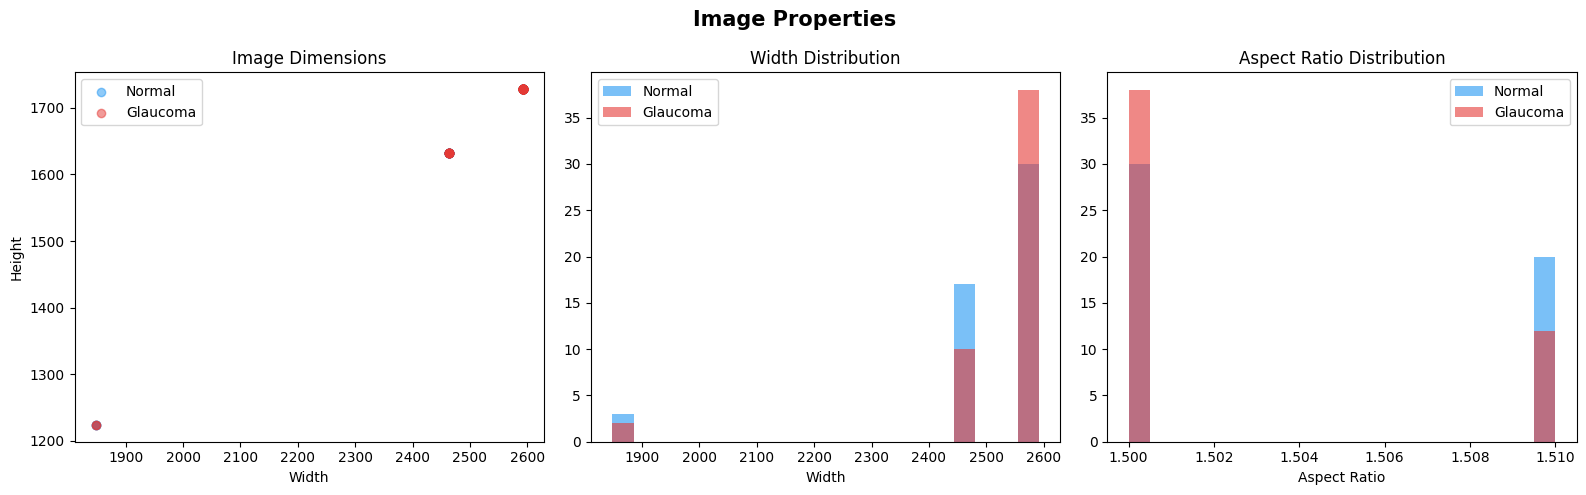

         width                                                        height  \
         count    mean    std     min     25%     50%     75%     max  count   
class                                                                          
Glaucoma  50.0  2536.6  151.0  1848.0  2592.0  2592.0  2592.0  2592.0   50.0   
Normal    50.0  2503.8  177.9  1848.0  2464.0  2592.0  2592.0  2592.0   50.0   

                                                                 
            mean    std     min     25%     50%     75%     max  
class                                                            
Glaucoma  1688.6  103.3  1224.0  1728.0  1728.0  1728.0  1728.0  
Normal    1665.1  121.3  1224.0  1632.0  1728.0  1728.0  1728.0  


In [4]:
sample_df = (
    df.groupby('class')
    .apply(lambda x: x.sample(min(50, len(x)), random_state=SEED))
    .reset_index(drop=True)
)

props = []
for _, row in sample_df.iterrows():
    try:
        img = Image.open(row['path'])
        w, h = img.size
        props.append({'class': row['class'], 'width': w, 'height': h,
                      'aspect_ratio': round(w / h, 3), 'mode': img.mode})
    except Exception:
        pass

props_df = pd.DataFrame(props)

fig, axes = plt.subplots(1, 3, figsize=(16, 5))
fig.suptitle('Image Properties', fontsize=15, fontweight='bold')

for cls, color in zip(CLASS_NAMES, COLORS):
    sub = props_df[props_df['class'] == cls]
    axes[0].scatter(sub['width'], sub['height'], alpha=0.5, label=cls, color=color)
axes[0].set_xlabel('Width')
axes[0].set_ylabel('Height')
axes[0].set_title('Image Dimensions')
axes[0].legend()

for cls, color in zip(CLASS_NAMES, COLORS):
    sub = props_df[props_df['class'] == cls]
    axes[1].hist(sub['width'], bins=20, alpha=0.6, label=cls, color=color)
axes[1].set_xlabel('Width')
axes[1].set_title('Width Distribution')
axes[1].legend()

for cls, color in zip(CLASS_NAMES, COLORS):
    sub = props_df[props_df['class'] == cls]
    axes[2].hist(sub['aspect_ratio'], bins=20, alpha=0.6, label=cls, color=color)
axes[2].set_xlabel('Aspect Ratio')
axes[2].set_title('Aspect Ratio Distribution')
axes[2].legend()

plt.tight_layout()
plt.show()

print(props_df.groupby('class')[['width', 'height']].describe().round(1))

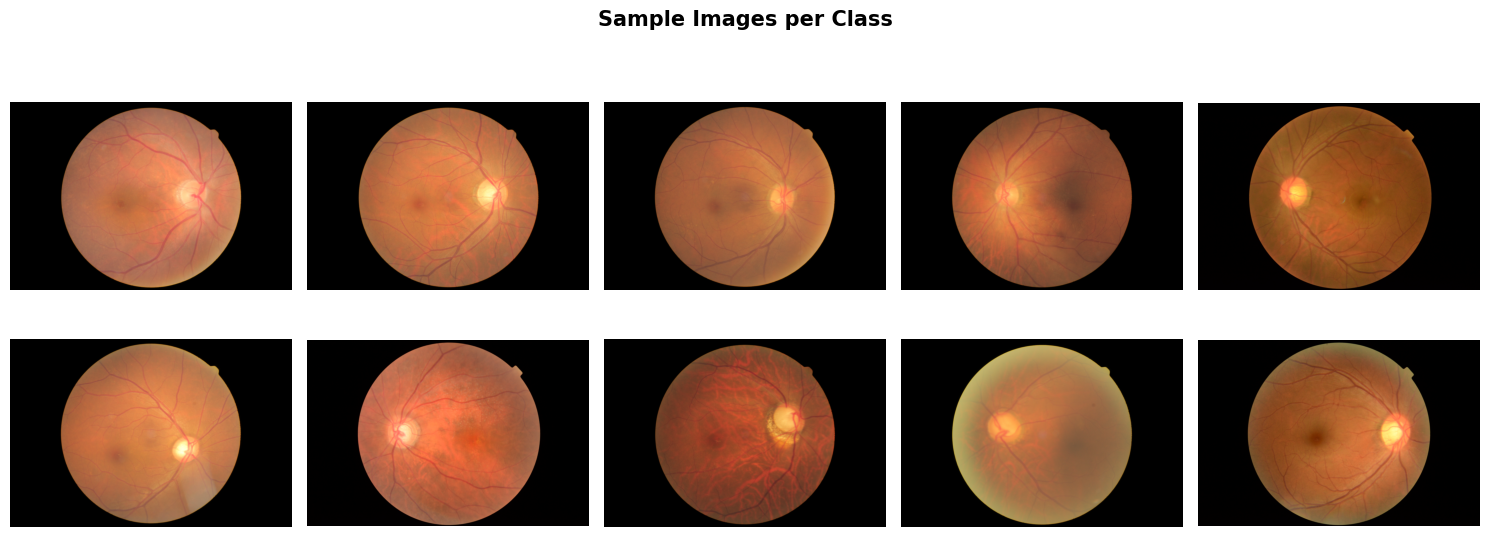

In [5]:
n_per_class = 5
fig, axes = plt.subplots(len(CLASS_NAMES), n_per_class,
                         figsize=(3 * n_per_class, 3 * len(CLASS_NAMES)))
fig.suptitle('Sample Images per Class', fontsize=15, fontweight='bold')

for row_idx, cls_name in enumerate(CLASS_NAMES):
    samples = df[df['class'] == cls_name].sample(n_per_class, random_state=SEED)
    for col_idx, (_, sample) in enumerate(samples.iterrows()):
        ax = axes[row_idx][col_idx]
        ax.imshow(Image.open(sample['path']).convert('RGB'))
        ax.axis('off')
        if col_idx == 0:
            ax.set_ylabel(cls_name, fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

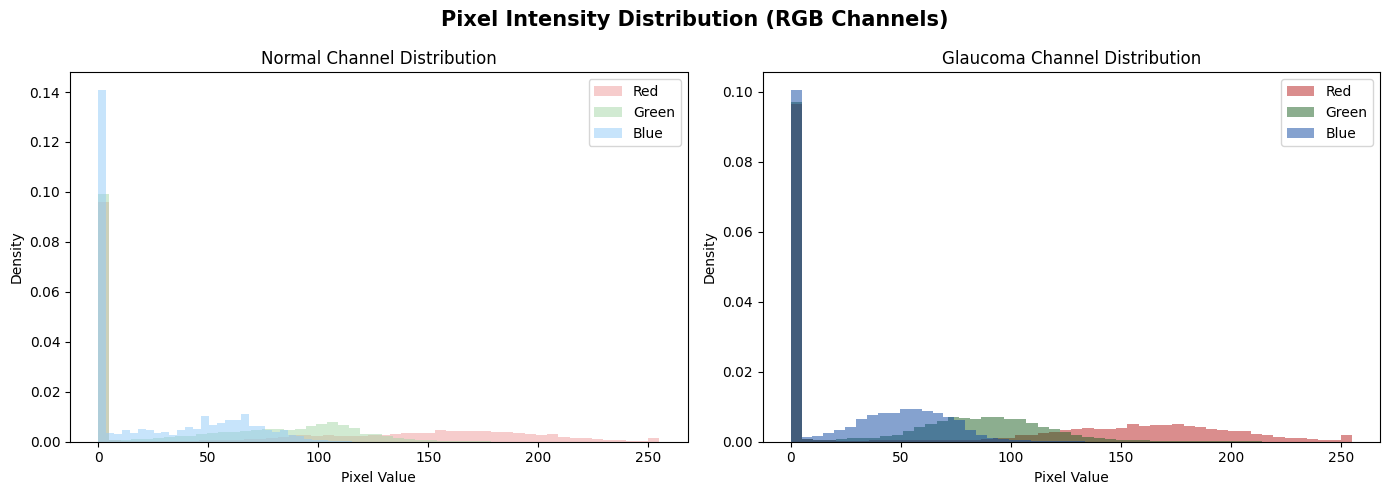

In [6]:
channel_names = ['Red', 'Green', 'Blue']
channel_color_map = {
    'Normal':   ['#EF9A9A', '#A5D6A7', '#90CAF9'],
    'Glaucoma': ['#B71C1C', '#1B5E20', '#0D47A1']
}

fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Pixel Intensity Distribution (RGB Channels)', fontsize=15, fontweight='bold')

for ax_idx, cls_name in enumerate(CLASS_NAMES):
    cls_samples = df[df['class'] == cls_name].sample(min(20, len(df[df['class'] == cls_name])), random_state=SEED)
    pixels = {0: [], 1: [], 2: []}
    for _, row in cls_samples.iterrows():
        arr = np.array(Image.open(row['path']).convert('RGB').resize((64, 64)))
        for c in range(3):
            pixels[c].extend(arr[:, :, c].flatten().tolist())
    for c, ch in enumerate(channel_names):
        axes[ax_idx].hist(pixels[c], bins=50, alpha=0.5,
                          label=ch, color=channel_color_map[cls_name][c], density=True)
    axes[ax_idx].set_title(f'{cls_name} Channel Distribution')
    axes[ax_idx].set_xlabel('Pixel Value')
    axes[ax_idx].set_ylabel('Density')
    axes[ax_idx].legend()

plt.tight_layout()
plt.show()

## 3. Preprocessing and Augmentation

In [7]:
train_df, temp_df = train_test_split(df, test_size=0.2, stratify=df['label'], random_state=SEED)
val_df, test_df   = train_test_split(temp_df, test_size=0.5, stratify=temp_df['label'], random_state=SEED)

print(f'Train: {len(train_df)}  |  Val: {len(val_df)}  |  Test: {len(test_df)}')
print('\nTrain class distribution:')
print(train_df['class'].value_counts())

Train: 320  |  Val: 40  |  Test: 41

Train class distribution:
class
Normal      239
Glaucoma     81
Name: count, dtype: int64


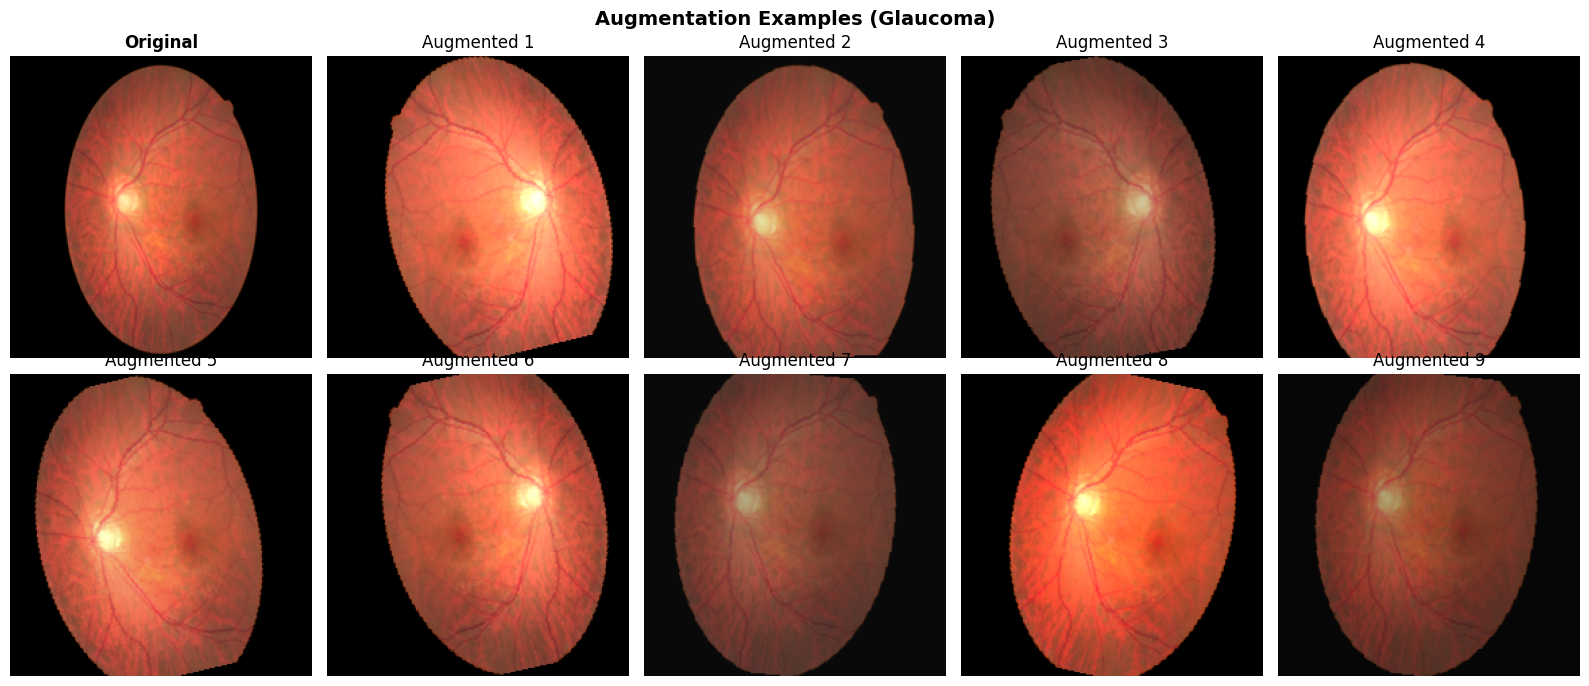

In [8]:
IMAGENET_MEAN = [0.485, 0.456, 0.406]
IMAGENET_STD  = [0.229, 0.224, 0.225]

train_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.2),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2, hue=0.1),
    transforms.RandomGrayscale(p=0.05),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

val_transforms = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=IMAGENET_MEAN, std=IMAGENET_STD)
])

preview_transform = transforms.Compose([
    transforms.Resize((IMG_SIZE + 32, IMG_SIZE + 32)),
    transforms.RandomCrop(IMG_SIZE),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(degrees=15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2)
])

sample_img = Image.open(df[df['class'] == 'Glaucoma'].iloc[0]['path']).convert('RGB')

fig, axes = plt.subplots(2, 5, figsize=(16, 7))
fig.suptitle('Augmentation Examples (Glaucoma)', fontsize=14, fontweight='bold')

axes[0][0].imshow(sample_img.resize((IMG_SIZE, IMG_SIZE)))
axes[0][0].set_title('Original', fontweight='bold')
axes[0][0].axis('off')

for i in range(1, 10):
    r, c = divmod(i, 5)
    axes[r][c].imshow(preview_transform(sample_img))
    axes[r][c].set_title(f'Augmented {i}')
    axes[r][c].axis('off')

plt.tight_layout()
plt.show()

In [9]:
class EyeDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.df = dataframe.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row   = self.df.iloc[idx]
        image = Image.open(row['path']).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image, int(row['label'])


class_counts   = train_df['label'].value_counts().sort_index().values
class_weights  = 1.0 / class_counts
sample_weights = [class_weights[label] for label in train_df['label']]
sampler = WeightedRandomSampler(weights=sample_weights, num_samples=len(sample_weights), replacement=True)

train_dataset = EyeDataset(train_df, transform=train_transforms)
val_dataset   = EyeDataset(val_df,   transform=val_transforms)
test_dataset  = EyeDataset(test_df,  transform=val_transforms)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, sampler=sampler,  num_workers=2, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=BATCH_SIZE, shuffle=False,    num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=BATCH_SIZE, shuffle=False,    num_workers=2, pin_memory=True)

print(f'Train batches: {len(train_loader)}  |  Val batches: {len(val_loader)}  |  Test batches: {len(test_loader)}')

Train batches: 10  |  Val batches: 2  |  Test batches: 2


## 4. Model Architecture

In [10]:
class GlaucomaClassifier(nn.Module):
    def __init__(self, num_classes=2, pretrained=True, dropout=0.4):
        super().__init__()
        self.backbone   = timm.create_model('efficientnet_b3', pretrained=pretrained, num_classes=0)
        in_features     = self.backbone.num_features
        self.classifier = nn.Sequential(
            nn.Linear(in_features, 512),
            nn.BatchNorm1d(512),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(512, 128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(dropout / 2),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        return self.classifier(self.backbone(x))


model = GlaucomaClassifier(num_classes=2, pretrained=True).to(DEVICE)

total_params     = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'Total parameters:     {total_params:,}')
print(f'Trainable parameters: {trainable_params:,}')

model.safetensors:   0%|          | 0.00/49.3M [00:00<?, ?B/s]

Total parameters:     11,550,378
Trainable parameters: 11,550,378


## 5. Training and Validation

In [11]:
weights_tensor = torch.tensor(class_weights / class_weights.sum(), dtype=torch.float).to(DEVICE)
criterion  = nn.CrossEntropyLoss(weight=weights_tensor)
optimizer  = optim.AdamW(model.parameters(), lr=LR, weight_decay=1e-4)
scheduler  = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=EPOCHS, eta_min=1e-6)


def train_epoch(model, loader, criterion, optimizer):
    model.train()
    total_loss, correct, total = 0.0, 0, 0
    for images, labels in loader:
        images, labels = images.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = model(images)
        loss    = criterion(outputs, labels)
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        total_loss += loss.item() * images.size(0)
        correct    += (outputs.argmax(dim=1) == labels).sum().item()
        total      += labels.size(0)
    return total_loss / total, correct / total


def eval_epoch(model, loader, criterion):
    model.eval()
    total_loss, correct, total = 0.0, 0, 0
    all_probs, all_labels = [], []
    with torch.no_grad():
        for images, labels in loader:
            images, labels = images.to(DEVICE), labels.to(DEVICE)
            outputs = model(images)
            loss    = criterion(outputs, labels)
            total_loss += loss.item() * images.size(0)
            probs   = torch.softmax(outputs, dim=1)[:, 1]
            correct += (outputs.argmax(dim=1) == labels).sum().item()
            total   += labels.size(0)
            all_probs.extend(probs.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    auc = roc_auc_score(all_labels, all_probs)
    return total_loss / total, correct / total, auc


history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': [], 'val_auc': []}
best_val_auc   = 0.0
best_model_path = '/kaggle/working/best_glaucoma_model.pth'

header = f'{"Epoch":>6} | {"Train Loss":>10} | {"Train Acc":>9} | {"Val Loss":>8} | {"Val Acc":>7} | {"Val AUC":>7}'
print(header)
print('-' * len(header))

for epoch in range(1, EPOCHS + 1):
    tr_loss, tr_acc         = train_epoch(model, train_loader, criterion, optimizer)
    vl_loss, vl_acc, vl_auc = eval_epoch(model, val_loader, criterion)
    scheduler.step()

    history['train_loss'].append(tr_loss)
    history['val_loss'].append(vl_loss)
    history['train_acc'].append(tr_acc)
    history['val_acc'].append(vl_acc)
    history['val_auc'].append(vl_auc)

    saved = '  <-- saved' if vl_auc > best_val_auc else ''
    if vl_auc > best_val_auc:
        best_val_auc = vl_auc
        torch.save(model.state_dict(), best_model_path)

    print(f'{epoch:>6} | {tr_loss:>10.4f} | {tr_acc:>8.2%} | {vl_loss:>8.4f} | {vl_acc:>6.2%} | {vl_auc:>7.4f}{saved}')

print(f'\nBest Val AUC: {best_val_auc:.4f}')

 Epoch | Train Loss | Train Acc | Val Loss | Val Acc | Val AUC
--------------------------------------------------------------
     1 |     0.6397 |   56.25% |   0.6835 | 80.00% |  0.7600  <-- saved
     2 |     0.5971 |   56.25% |   0.6719 | 57.50% |  0.7133
     3 |     0.5996 |   54.37% |   0.6508 | 50.00% |  0.7000
     4 |     0.5294 |   63.44% |   0.6263 | 45.00% |  0.7533
     5 |     0.5181 |   64.38% |   0.6272 | 47.50% |  0.7767  <-- saved
     6 |     0.4831 |   67.50% |   0.6305 | 45.00% |  0.7900  <-- saved
     7 |     0.4464 |   70.62% |   0.6232 | 50.00% |  0.7600
     8 |     0.4131 |   72.81% |   0.6029 | 57.50% |  0.7900
     9 |     0.4255 |   68.44% |   0.6130 | 52.50% |  0.7667
    10 |     0.3677 |   76.25% |   0.5688 | 62.50% |  0.7933  <-- saved
    11 |     0.3377 |   79.38% |   0.5618 | 60.00% |  0.7967  <-- saved
    12 |     0.3489 |   78.12% |   0.5532 | 62.50% |  0.8133  <-- saved
    13 |     0.3073 |   81.56% |   0.5393 | 62.50% |  0.8200  <-- saved
    

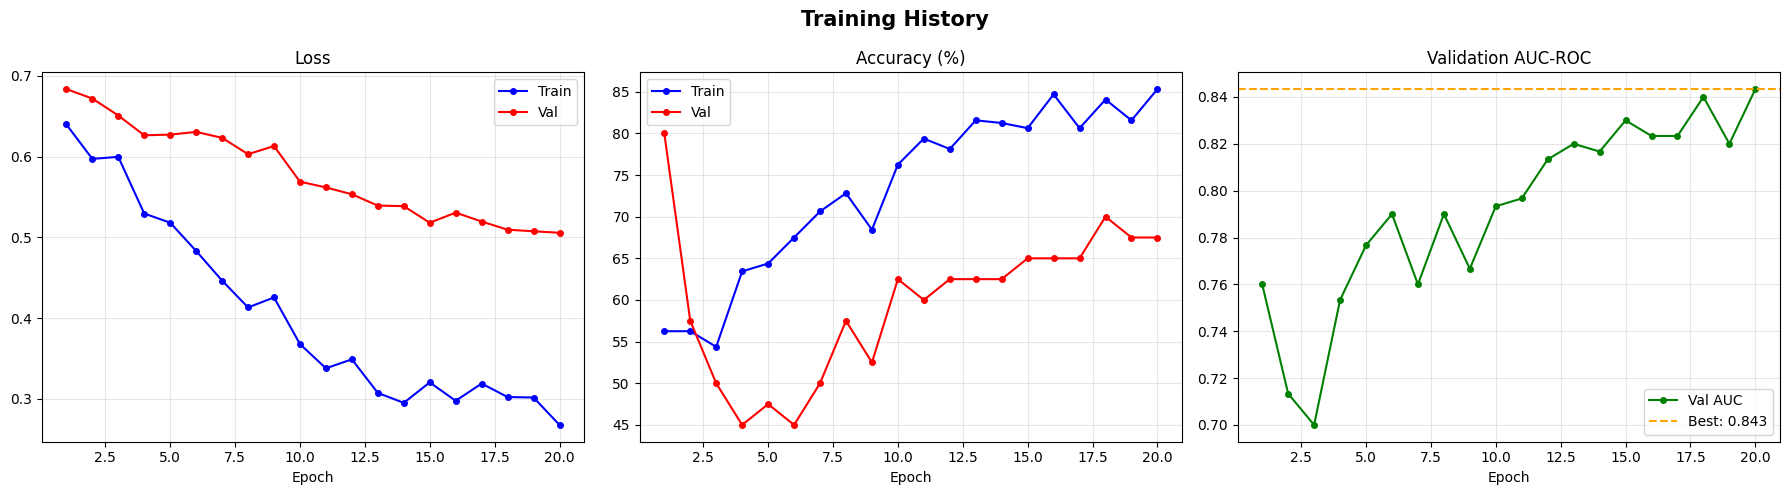

In [12]:
epochs_range = range(1, EPOCHS + 1)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Training History', fontsize=15, fontweight='bold')

axes[0].plot(epochs_range, history['train_loss'], 'b-o', markersize=4, label='Train')
axes[0].plot(epochs_range, history['val_loss'],   'r-o', markersize=4, label='Val')
axes[0].set_title('Loss')
axes[0].set_xlabel('Epoch')
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].plot(epochs_range, [a * 100 for a in history['train_acc']], 'b-o', markersize=4, label='Train')
axes[1].plot(epochs_range, [a * 100 for a in history['val_acc']],   'r-o', markersize=4, label='Val')
axes[1].set_title('Accuracy (%)')
axes[1].set_xlabel('Epoch')
axes[1].legend()
axes[1].grid(alpha=0.3)

axes[2].plot(epochs_range, history['val_auc'], 'g-o', markersize=4, label='Val AUC')
axes[2].axhline(best_val_auc, color='orange', linestyle='--', label=f'Best: {best_val_auc:.3f}')
axes[2].set_title('Validation AUC-ROC')
axes[2].set_xlabel('Epoch')
axes[2].legend()
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Evaluation

In [13]:
model.load_state_dict(torch.load(best_model_path, map_location=DEVICE))
model.eval()

all_preds, all_labels, all_probs = [], [], []

with torch.no_grad():
    for images, labels in test_loader:
        outputs = model(images.to(DEVICE))
        probs   = torch.softmax(outputs, dim=1)[:, 1].cpu().numpy()
        preds   = outputs.argmax(dim=1).cpu().numpy()
        all_preds.extend(preds)
        all_labels.extend(labels.numpy())
        all_probs.extend(probs)

all_preds  = np.array(all_preds)
all_labels = np.array(all_labels)
all_probs  = np.array(all_probs)

print('Classification Report (Test Set)')
print(classification_report(all_labels, all_preds, target_names=CLASS_NAMES))
print(f'AUC-ROC : {roc_auc_score(all_labels, all_probs):.4f}')
print(f'F1 Score: {f1_score(all_labels, all_preds):.4f}')

Classification Report (Test Set)
              precision    recall  f1-score   support

      Normal       0.88      0.71      0.79        31
    Glaucoma       0.44      0.70      0.54        10

    accuracy                           0.71        41
   macro avg       0.66      0.70      0.66        41
weighted avg       0.77      0.71      0.73        41

AUC-ROC : 0.7806
F1 Score: 0.5385


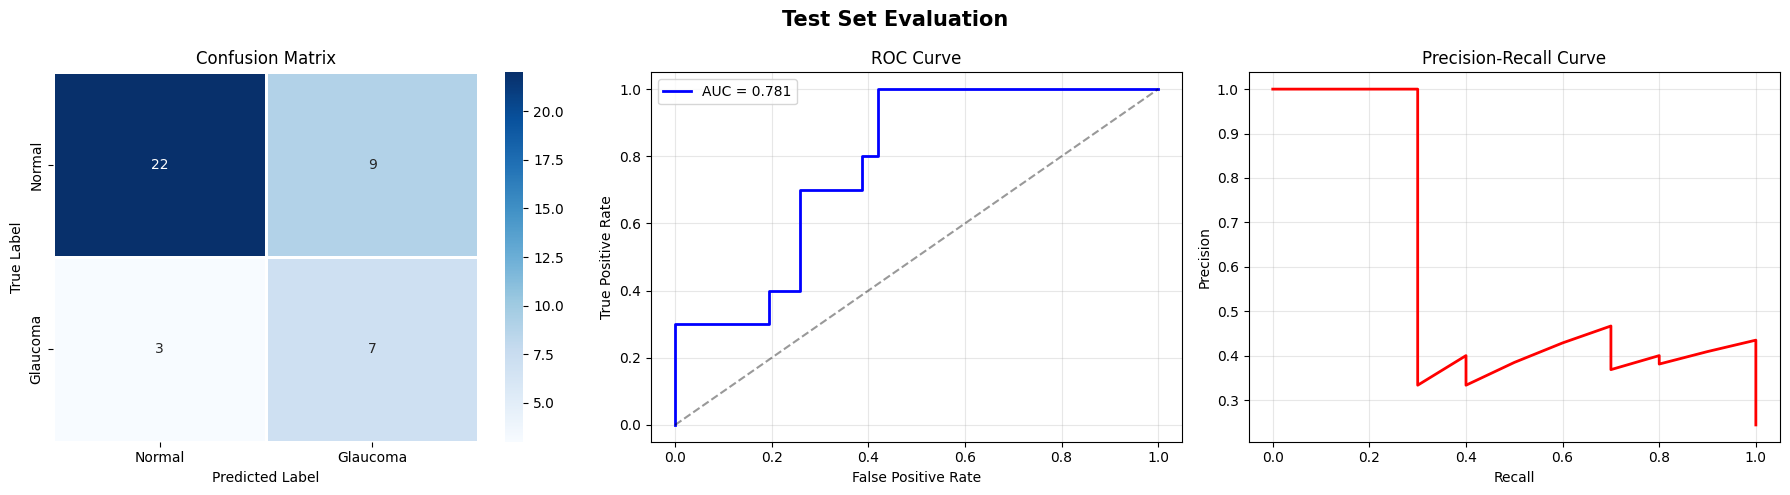

In [14]:
auc_score = roc_auc_score(all_labels, all_probs)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.suptitle('Test Set Evaluation', fontsize=15, fontweight='bold')

cm = confusion_matrix(all_labels, all_preds)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=CLASS_NAMES, yticklabels=CLASS_NAMES, linewidths=1)
axes[0].set_title('Confusion Matrix')
axes[0].set_ylabel('True Label')
axes[0].set_xlabel('Predicted Label')

fpr, tpr, _ = roc_curve(all_labels, all_probs)
axes[1].plot(fpr, tpr, 'b-', lw=2, label=f'AUC = {auc_score:.3f}')
axes[1].plot([0, 1], [0, 1], 'k--', alpha=0.4)
axes[1].set_xlabel('False Positive Rate')
axes[1].set_ylabel('True Positive Rate')
axes[1].set_title('ROC Curve')
axes[1].legend()
axes[1].grid(alpha=0.3)

precision, recall, _ = precision_recall_curve(all_labels, all_probs)
axes[2].plot(recall, precision, 'r-', lw=2)
axes[2].set_xlabel('Recall')
axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve')
axes[2].grid(alpha=0.3)

plt.tight_layout()
plt.show()

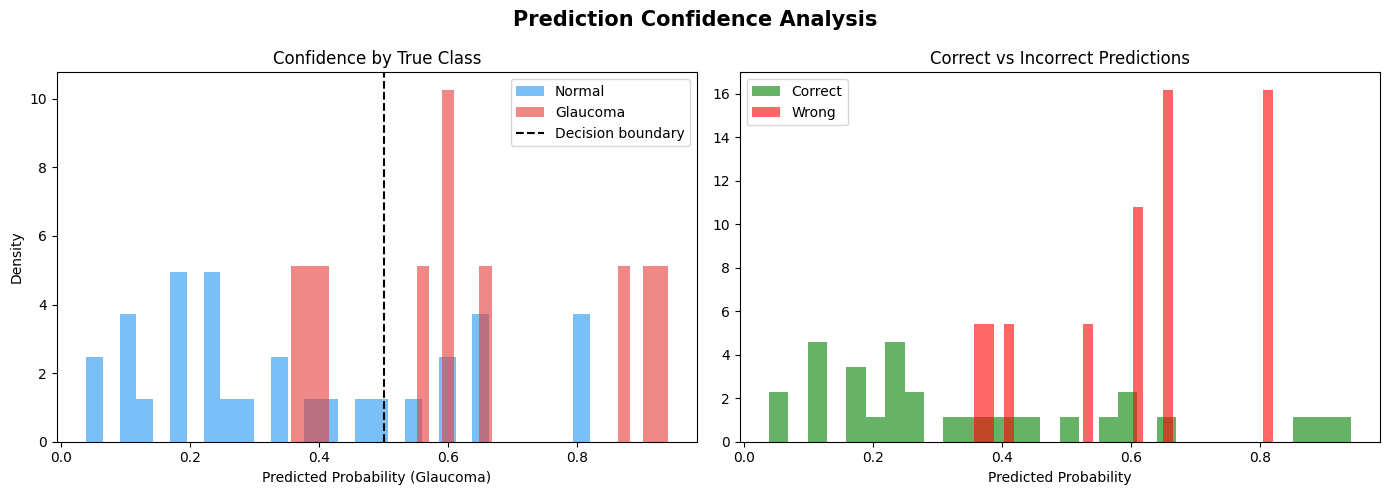

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.suptitle('Prediction Confidence Analysis', fontsize=15, fontweight='bold')

for cls_idx, cls_name in enumerate(CLASS_NAMES):
    mask = all_labels == cls_idx
    axes[0].hist(all_probs[mask], bins=30, alpha=0.6, label=cls_name, color=COLORS[cls_idx], density=True)
axes[0].axvline(0.5, color='black', linestyle='--', label='Decision boundary')
axes[0].set_xlabel('Predicted Probability (Glaucoma)')
axes[0].set_ylabel('Density')
axes[0].set_title('Confidence by True Class')
axes[0].legend()

correct_mask = all_preds == all_labels
axes[1].hist(all_probs[correct_mask],  bins=30, alpha=0.6, color='green', label='Correct', density=True)
axes[1].hist(all_probs[~correct_mask], bins=30, alpha=0.6, color='red',   label='Wrong',   density=True)
axes[1].set_xlabel('Predicted Probability')
axes[1].set_title('Correct vs Incorrect Predictions')
axes[1].legend()

plt.tight_layout()
plt.show()

## 7. Grad-CAM Visualization

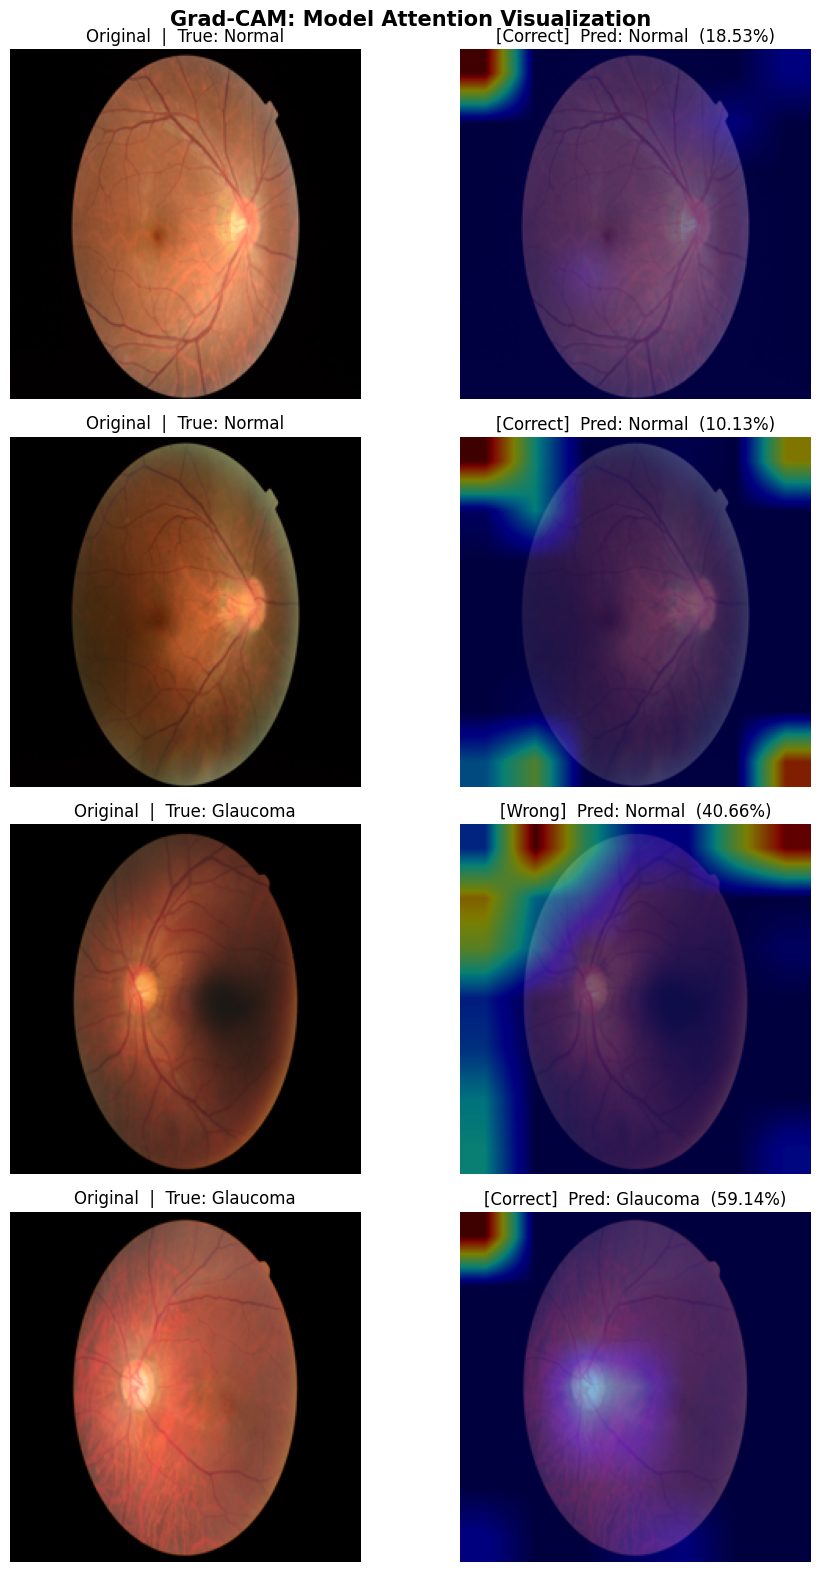

In [16]:
import cv2

class GradCAM:
    def __init__(self, model, target_layer):
        self.model       = model
        self.gradients   = None
        self.activations = None
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        self.gradients = grad_output[0].detach()

    def __call__(self, x, class_idx=None):
        self.model.eval()
        output = self.model(x)
        if class_idx is None:
            class_idx = output.argmax(dim=1).item()
        self.model.zero_grad()
        output[0, class_idx].backward()
        weights = self.gradients.mean(dim=(2, 3), keepdim=True)
        cam     = torch.relu((weights * self.activations).sum(dim=1, keepdim=True))
        cam     = (cam - cam.min()) / (cam.max() + 1e-8)
        return cam.squeeze().cpu().numpy(), class_idx


target_layer = model.backbone.blocks[-1][-1].conv_pw
grad_cam     = GradCAM(model, target_layer)


def get_cam_overlay(img_path, true_label):
    img_orig   = Image.open(img_path).convert('RGB')
    img_tensor = val_transforms(img_orig).unsqueeze(0).to(DEVICE)
    img_tensor.requires_grad_(True)

    cam, pred_idx = grad_cam(img_tensor)
    prob          = torch.softmax(model(img_tensor), dim=1)[0, 1].item()

    cam_resized = cv2.resize(cam, (IMG_SIZE, IMG_SIZE))
    heatmap     = plt.cm.jet(cam_resized)[:, :, :3]
    img_arr     = np.array(img_orig.resize((IMG_SIZE, IMG_SIZE))) / 255.0
    overlay     = np.clip(0.5 * img_arr + 0.5 * heatmap, 0, 1)

    return img_arr, overlay, prob, CLASS_NAMES[pred_idx], CLASS_NAMES[true_label]


vis_samples = pd.concat([
    test_df[test_df['class'] == 'Normal'].sample(2, random_state=SEED),
    test_df[test_df['class'] == 'Glaucoma'].sample(2, random_state=SEED)
]).reset_index(drop=True)

fig, axes = plt.subplots(4, 2, figsize=(10, 16))
fig.suptitle('Grad-CAM: Model Attention Visualization', fontsize=15, fontweight='bold')

for i, (_, row) in enumerate(vis_samples.iterrows()):
    img_arr, overlay, prob, pred_cls, true_cls = get_cam_overlay(row['path'], row['label'])
    status = '[Correct]' if pred_cls == true_cls else '[Wrong]'

    axes[i][0].imshow(img_arr)
    axes[i][0].set_title(f'Original  |  True: {true_cls}')
    axes[i][0].axis('off')

    axes[i][1].imshow(overlay)
    axes[i][1].set_title(f'{status}  Pred: {pred_cls}  ({prob:.2%})')
    axes[i][1].axis('off')

plt.tight_layout()
plt.show()

## 8. Model Export

Three export formats are provided:
- **PyTorch state dict** — for resuming training or fine-tuning
- **Full model** — easiest to reload for inference without re-defining the class
- **ONNX** — framework-agnostic, works with OpenCV, TensorRT, etc.

In [17]:
import json

EXPORT_DIR = Path('/kaggle/working/glaucoma_model_export')
EXPORT_DIR.mkdir(parents=True, exist_ok=True)

# Save model config alongside weights so inference code can reconstruct the architecture
model_config = {
    'architecture': 'efficientnet_b3',
    'num_classes':  2,
    'class_names':  CLASS_NAMES,
    'img_size':     IMG_SIZE,
    'imagenet_mean': IMAGENET_MEAN,
    'imagenet_std':  IMAGENET_STD
}

with open(EXPORT_DIR / 'model_config.json', 'w') as f:
    json.dump(model_config, f, indent=2)


# 1. State dict
state_dict_path = EXPORT_DIR / 'glaucoma_state_dict.pth'
torch.save(model.state_dict(), state_dict_path)
print(f'State dict saved  : {state_dict_path}')


# 2. Full model
full_model_path = EXPORT_DIR / 'glaucoma_full_model.pth'
torch.save(model, full_model_path)
print(f'Full model saved  : {full_model_path}')


# 3. ONNX export
onnx_path  = EXPORT_DIR / 'glaucoma_model.onnx'
dummy_input = torch.randn(1, 3, IMG_SIZE, IMG_SIZE).to(DEVICE)

model.eval()
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=12,
    input_names=['input'],
    output_names=['output'],
    dynamic_axes={'input': {0: 'batch_size'}, 'output': {0: 'batch_size'}}
)
print(f'ONNX model saved  : {onnx_path}')

print('\nExport complete. Files in', EXPORT_DIR)
for f in sorted(EXPORT_DIR.iterdir()):
    size_mb = f.stat().st_size / (1024 ** 2)
    print(f'  {f.name:<40} {size_mb:>7.2f} MB')

State dict saved  : /kaggle/working/glaucoma_model_export/glaucoma_state_dict.pth
Full model saved  : /kaggle/working/glaucoma_model_export/glaucoma_full_model.pth


ModuleNotFoundError: No module named 'onnxscript'